### One of the Main Strengths in Julia is its Convenience in Implementing CPU Parallel Computing. Below Check First the Number of Threads Being Used

In [1]:
#The number of threads being used is set in the enviromental variables in Windows system (ask chatgpt for further details). 
#My computer has 8 CPU cores and 16 LUs, so 8 threads are used here.
using Base.Threads
println("Number of Threads:",nthreads())

Number of Threads:8


In [5]:
print(Int64.(1:10))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Generator Validity Verification

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


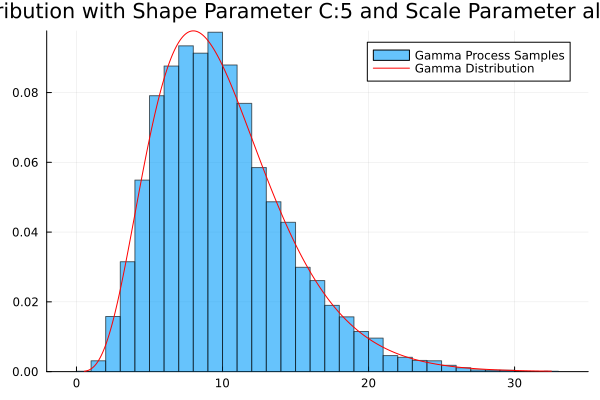

In [1]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter
N = 10000 # 样本数量
T = 1 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1 / beta # 生成时的比例参数
C = 5 # 速率/形状参数
samples = Float64[]

@showprogress for i in 1:N
    samples_matrix, jump_time_matrix = Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, 1, 1, 100)
    gamma_jumps = samples_matrix[1, :]
    gamma_jump_times = jump_time_matrix[1, :]
    sample = Julia_Implementation.integrate([1.0], gamma_jumps, gamma_jump_times)
    push!(samples, sample[1])
end

# 定义x的范围，以匹配samples的范围或更广
x = range(minimum(samples), stop=maximum(samples), length=1000)

p = histogram(samples, bins=50, normalize=true, alpha=0.6, label="Gamma Process Samples")
plot!(p, x, pdf.(Gamma(C, alpha), x), color=:red, label="Gamma Distribution")
title!(p, "Gamma Distribution with Shape Parameter C:$(C) and Scale Parameter alpha (1/beta):$(alpha)")
#legend!(:topright) # 如果需要图例，取消这行注释
display(p)


### SDE Samples and Samples Masked with Noise

In [2]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]'
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")
subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 100)# subordinator jump sizes and times

([0.0 0.0 … 0.04872237573486578 0.04674181982780386], [13.58225313264994 17.031723642954212 … 3.8604479866596297 12.757972453425833])

In [10]:
println(size(subordinator_jumps))
println(size(jump_times[1,:]))

(1, 100)
(100,)


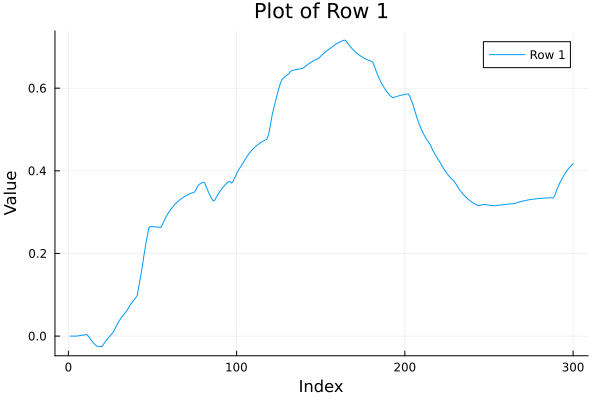

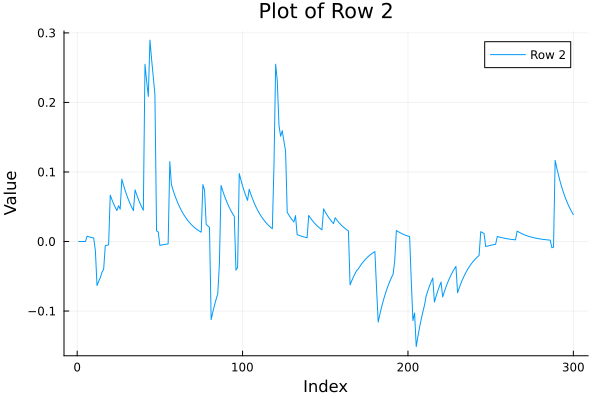

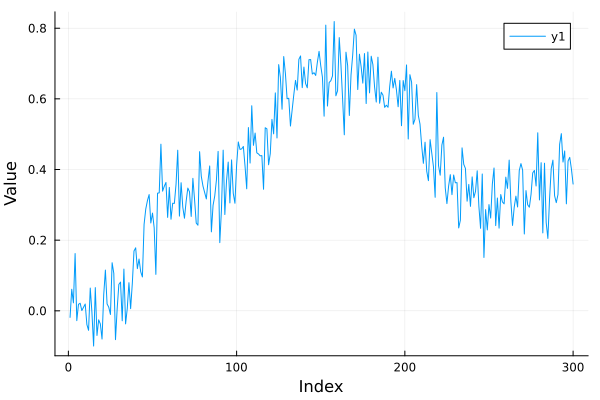

In [1]:
include("Julia_Implementation.jl")
using Random
import Pkg # Pkg is the package manager in Julia
using Distributions
using Plots
using LinearAlgebra
using ProgressMeter

# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 1000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
# 模拟
evaluation_points = range(0, T, length=N)
#print("Hi")
subordinator_jumps, jump_times = Julia_Implementation.vectorized_particle_Gamma_generator(true_beta, true_C, T, 1, 1, 100)# subordinator jump sizes and times
samples = Julia_Implementation.generate_SDE_samples(subordinator_jumps[1,:],jump_times[1,:],true_muw,true_sigmaw,A,h,evaluation_points)
#print(size(samples))
# 分开绘制每一行
for i in 1:size(samples, 1)
    plot(samples[i, :], label=string("Row ", i))
    title!("Plot of Row $i")
    xlabel!("Index")
    ylabel!("Value")
    display(plot!()) # 使用 display 来显示图表
end

# 生成噪声观测数据
Noisy_samples = samples[1, :] .+ randn(length(samples[1, :])) .* sigma_n

#print(size(Noisy_samples))
# 下一步是基于这些数据进行参数估计或其他分析，这部分代码取决于具体的分析目标
plot(Noisy_samples)
xlabel!("Index")
ylabel!("Value")
display(plot!())





### Broadcasting Experiment. Broadcast元素是整个[]，关键看怎么定义[],非常灵活。 Julia在实际物件上是没有高维数组的定义的，只有1和2维不断叠加

In [29]:
# 定义矩阵 A 和 B
using Base.Threads
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C_2D = repeat(matrix_A,2,2)
println(matrix_C_2D) #注意结果仍然是个2D矩阵

matrix_C_desired = repeat([matrix_A],2,2) #此结果依旧是2D矩阵，但是每个元素也还是个2D的矩阵，超级方便好理解。之后直接elementwise运算应用，无敌方便

[1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0; 1.0 1.0 1.0 1.0]


2×2 Matrix{Matrix{Float64}}:
 [1.0 1.0; 1.0 1.0]  [1.0 1.0; 1.0 1.0]
 [1.0 1.0; 1.0 1.0]  [1.0 1.0; 1.0 1.0]

In [32]:
#Scalar Compatible!!!!
size(1,1)
size(1,2)

1

In [2]:
#The Problem of Common Reference
mat1 = [1 2; 3 4]
array_of_matrices = repeat([mat1], 2, 2)
array_of_matrices[1, 1][1, 1] = 99
println(array_of_matrices)


[[99 2; 3 4] [99 2; 3 4]; [99 2; 3 4] [99 2; 3 4]]


In [1]:
# 定义矩阵 A 和 B
using Base.Threads
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C = ones(2, 2, 2000, 2000)  # 这里简化了初始化过程，实际可以按需要赋值
result_elementwise = matrix_C .* matrix_B #关键是进去之后还是点乘而非矩阵乘法
#println(result_elementwise)


# 初始化结果数组，保持与 matrix_C 相同的四维结构
result_matrix_mult = similar(matrix_C)

# 执行矩阵乘法
@threads for i in 1:size(matrix_C, 3)
    @threads for j in 1:size(matrix_C, 4)
        result_matrix_mult[:, :, i, j] = matrix_B * matrix_C[:, :, i, j]  #想要非点乘的矩阵乘法只能用for loop
    end
end

# 输出结果，查看四维数组中的矩阵乘法结果
#println(result_matrix_mult)

In [9]:
matrix_A = ones(2, 2)
matrix_B = [1 2; 3 4]  # 直接定义，简化创建过程

# 定义四维矩阵 C，每个元素是 2x2 矩阵，全部初始化为 1
matrix_C = ones(size(matrix_B,1),size(matrix_B,2),2000,2000)  # 这里简化了初始化过程，实际可以按需要赋值
result_elementwise = matrix_C .* matrix_B #关键是进去之后还是点乘而非矩阵乘法

2×2×2000×2000 Array{Float64, 4}:
[:, :, 1, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 1] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 1] =
 1.0  2.0
 3.0  4.0

[:, :, 1, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 2] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 2] =
 1.0  2.0
 3.0  4.0

[:, :, 1, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 3] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 3] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 3] =
 1.0  2.0
 3.0  4.0

;;;; … 

[:, :, 1, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 2, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 3, 1998] =
 1.0  2.0
 3.0  4.0

;;; … 

[:, :, 1998, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 1999, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 2000, 1998] =
 1.0  2.0
 3.0  4.0

[:, :, 1

In [1]:
include("Julia_Implementation.jl")
N = 1000 #
T = 100 # 模拟时间
beta = 0.5 # 逆比例参数
alpha = 1 / beta # 生成时的比例参数
C = 5 # 速率/形状参数
Julia_Implementation.vectorized_particle_Gamma_generator(beta, C, T, N, 1000, 100);

### Marginalised Particle Filter Implementation

In [1]:
include("Julia_Implementation.jl")
# 参数初始化
beta_pcn = 1.0 # 预条件Crank-Nicolson算法的步长参数
n_iter = 300 # 迭代次数
theta0 = -1.0 # theta的初始猜测
beta0 = 5.0 # beta的初始猜测
C0 = 2.0 # C的初始猜测
num_particles = 10000

# 三个参数的步长
l_theta = 1.0
l_beta = 0.1
l_C = 2.0

# 真实参数值
true_theta = -1.0
kw = 1.0
kv = 0.1
true_sigmaw = 0.2
true_muw = 0.2
sigma_n = true_sigmaw * sqrt(kv)

# 模拟参数
true_beta = 5.0
true_C = 2.0
T = 30.0
N = 10 * round(Int,T) # 分辨率

# 定义Langevin动力学
A = zeros(2, 2)
A[1, 2] = 1.0
A[2, 2] = true_theta
h = [0.0, 1.0]
mean_matrix, cov_matrix = Julia_Implementation.vectorized_particle_transition_function(true_beta, true_C, T, N, num_particles, A, h ;c=10)
println(size(mean_matrix))
println(size(cov_matrix))


(1000, 300)(1000, 300)